In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Magnitude')
    plt.plot(predicted, color='blue',label='Predicted Magnitude')
    plt.title('Earthquake Magnitude Prediction')
    plt.xlabel('Time')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
!git clone "https://github.com/bharatb010699/Earthquake-Forecasting.git"

Cloning into 'Earthquake-Forecasting'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 36 (delta 13), reused 18 (delta 6), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [6]:
# First, we get the data
dataset = pd.read_csv('/content/Earthquake-Forecasting/query.csv', index_col='time', parse_dates=['time'])
dataset = dataset[['latitude', 'longitude', 'depth', 'mag']]
dataset = dataset.iloc[::-1]
dataset.head()

,latitude,longitude,depth,mag
time,,,,
1920-10-12 06:54:51+00:00,35.426,80.532,20.0,6.7
1921-11-15 20:36:43+00:00,36.202,70.711,240.0,7.8
1922-10-16 16:01:37+00:00,39.136,89.751,10.0,6.3
1923-10-01 08:16:28+00:00,29.012,70.033,15.0,6.3
1924-07-03 04:40:12+00:00,36.983,84.164,10.0,7.0


In [11]:
# Checking for missing values
training_set = dataset['2012':'2018'].iloc[:,1:2].values
test_set = dataset['2019':].iloc[:,1:2].values

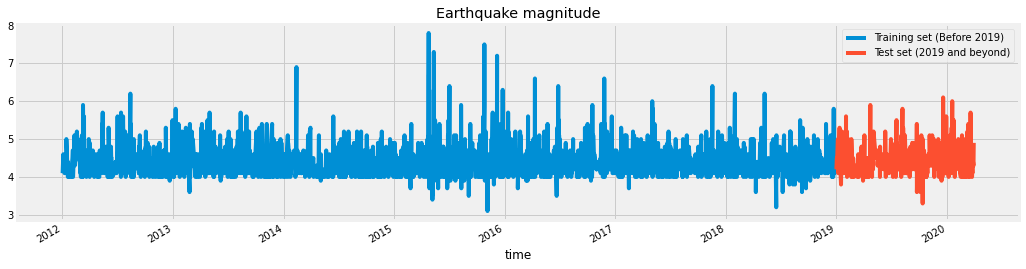

In [13]:
# We have chosen 'mag' attribute. Let's see what it looks like
dataset["mag"]['2012':'2018'].plot(figsize=(16,4),legend=True)
dataset["mag"]['2019':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2019)','Test set (2019 and beyond)'])
plt.title('Earthquake magnitude')
plt.show()

In [14]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [17]:
print(len(training_set))
print(len(test_set))

3268
477


In [20]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,len(training_set)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [24]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

In [26]:
# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=16)

Epoch 1/50
3208/3208 [==============================] - 116s 36ms/step - loss: 0.0873
Epoch 2/50
3208/3208 [==============================] - 115s 36ms/step - loss: 0.0864
Epoch 3/50
3208/3208 [==============================] - 115s 36ms/step - loss: 0.0861
Epoch 4/50
3208/3208 [==============================] - 114s 35ms/step - loss: 0.0858
Epoch 5/50
3208/3208 [==============================] - 113s 35ms/step - loss: 0.0856
Epoch 6/50
3208/3208 [==============================] - 114s 35ms/step - loss: 0.0851
Epoch 7/50
3208/3208 [==============================] - 114s 35ms/step - loss: 0.0843
Epoch 8/50
3208/3208 [==============================] - 113s 35ms/step - loss: 0.0838
Epoch 9/50
3208/3208 [==============================] - 113s 35ms/step - loss: 0.0840
Epoch 10/50
3208/3208 [==============================] - 113s 35ms/step - loss: 0.0836
Epoch 11/50
3208/3208 [==============================] - 113s 35ms/step - loss: 0.0829
Epoch 12/50
3208/3208 [=============================

In [28]:
regressor.save('/content/Earthquake-Forecasting/lstm_model.h5')

In [29]:
regressor.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [30]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so first 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'mag' attribute data for processing
dataset_total = pd.concat((dataset["mag"]['2012':'2018'],dataset["mag"]['2019':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [31]:
X_test = []
for i in range(60,len(test_set)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_mag = regressor.predict(X_test)
predicted_mag = sc.inverse_transform(predicted_mag)

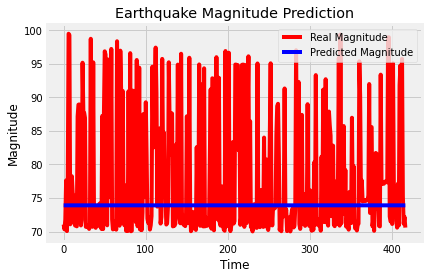

In [37]:
# Visualizing the results for LSTM
plot_predictions(test_set[:len(test_set)-60], predicted_mag)

In [38]:
# Evaluating our model
return_rmse(test_set[:len(test_set)-60], predicted_mag)

The root mean squared error is 9.79910529942502.
